# Sieci konwolucyjne część 2.

**Uwaga:** Poniższy notebook jest stworzony z myślą o uruchamianiu go w [Colaboratory](https://colab.research.google.com/) (link do przeglądania repozytoriów w colabie: [link](https://colab.research.google.com/github/)), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania pracy domowej.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from torchvision.transforms import (RandomVerticalFlip,
                                    ToTensor)
import torch
import torch.nn as nn
import torch.optim as optim

### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

Files already downloaded and verified
CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


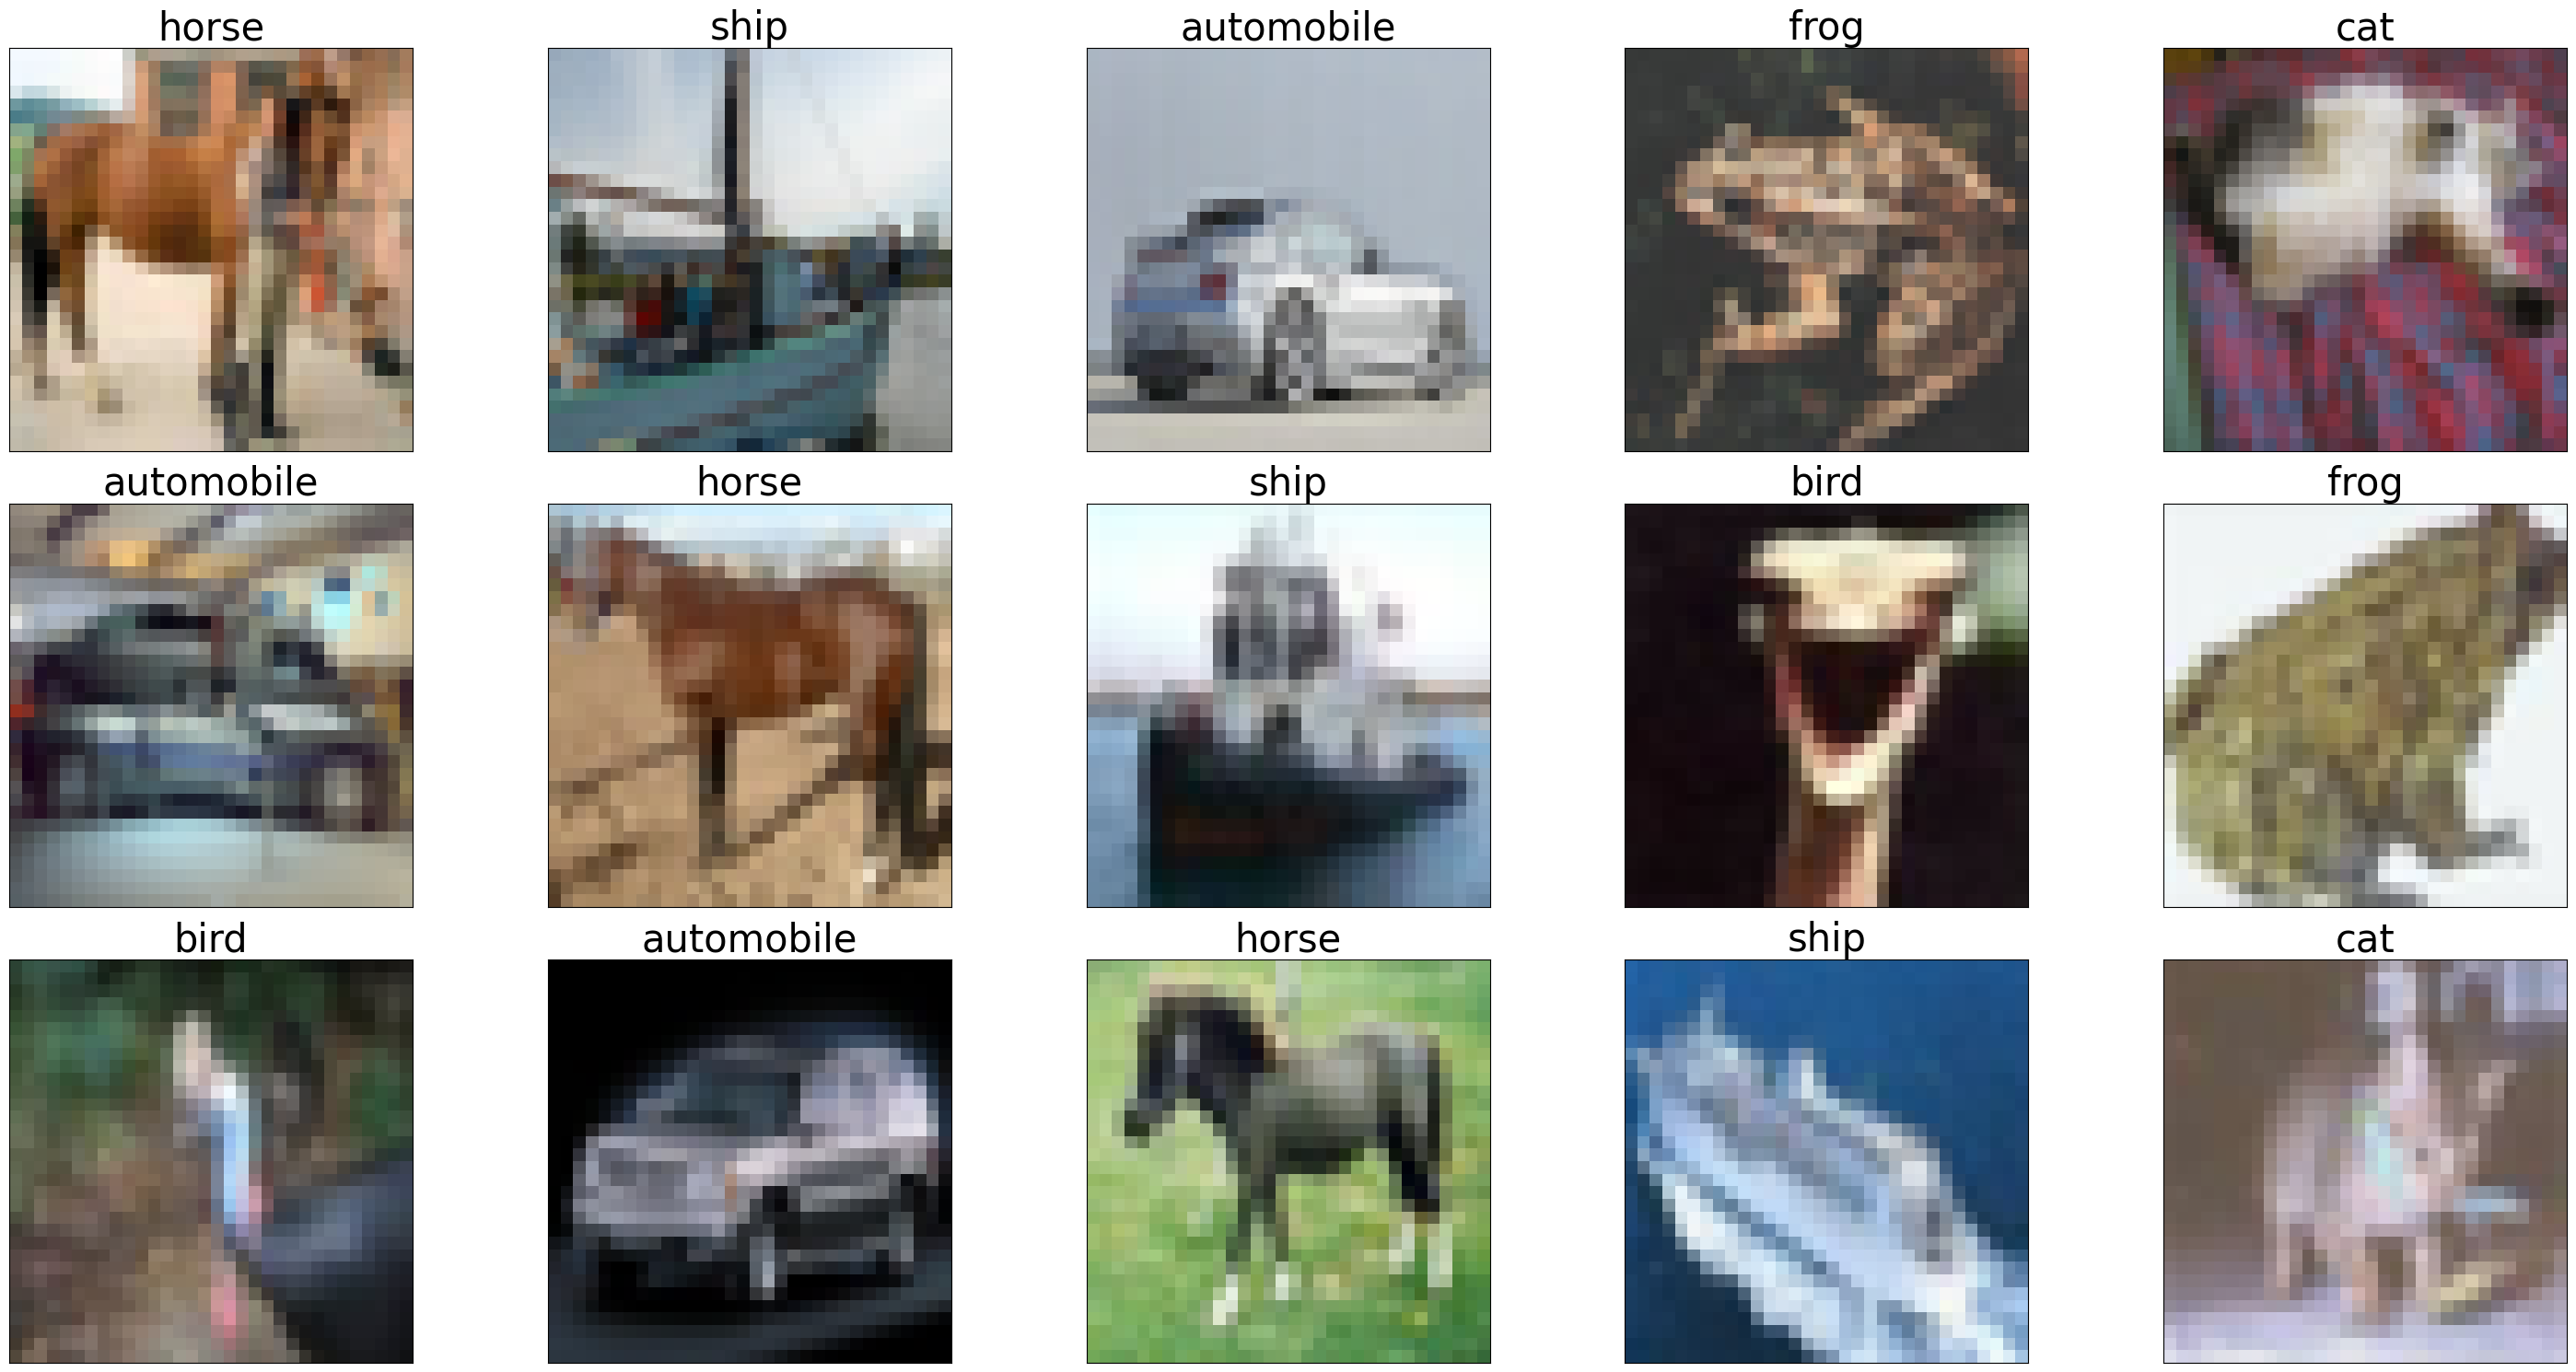

In [2]:
dataset = CIFAR10(root=".", train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={"size": 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 1. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch_size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [3]:
# tutaj zdefiniuj swój model, nie zapomnij o dziedziczeniu z torch.nn.Module

import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.dropout2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(256*64, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(-1, 256*64)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=16384, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [4]:
# tutaj uzupełnij ładowanie danych treningowych i testowych
from torchvision import transforms
from torchvision.transforms import ToTensor, RandomHorizontalFlip, RandomVerticalFlip, ColorJitter, RandomRotation, Normalize

transform_train = transforms.Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10(root='.',
                        train=True,
                        download=True,
                        transform=transform_train)

test_dataset = CIFAR10(root='.',
                       train=False,
                       download=True,
                       transform=transform_test)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
learning_rate = 0.001
epochs = 20

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)

    accuracy = correct / total
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}')


#Final evaluation on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Final Test Accuracy: {accuracy:.4f}')

Epoch 1/20, Loss: 0.9462, Accuracy: 0.6742
Epoch 2/20, Loss: 0.7418, Accuracy: 0.7393
Epoch 3/20, Loss: 0.6655, Accuracy: 0.7733
Epoch 4/20, Loss: 0.6863, Accuracy: 0.7758
Epoch 5/20, Loss: 0.7204, Accuracy: 0.7783
Epoch 6/20, Loss: 0.8748, Accuracy: 0.7735
Epoch 7/20, Loss: 0.9405, Accuracy: 0.7697
Epoch 8/20, Loss: 1.0636, Accuracy: 0.7670
Epoch 9/20, Loss: 0.9997, Accuracy: 0.7824
Epoch 10/20, Loss: 1.1582, Accuracy: 0.7770
Epoch 11/20, Loss: 1.2779, Accuracy: 0.7663
Epoch 12/20, Loss: 1.1440, Accuracy: 0.7753
Epoch 13/20, Loss: 1.2046, Accuracy: 0.7773
Epoch 14/20, Loss: 1.2390, Accuracy: 0.7728
Epoch 15/20, Loss: 1.2361, Accuracy: 0.7742
Epoch 16/20, Loss: 1.2599, Accuracy: 0.7778
Epoch 17/20, Loss: 1.3128, Accuracy: 0.7814
Epoch 18/20, Loss: 1.3755, Accuracy: 0.7763
Epoch 19/20, Loss: 1.3342, Accuracy: 0.7800
Epoch 20/20, Loss: 1.3717, Accuracy: 0.7728
Final Test Accuracy: 0.7728


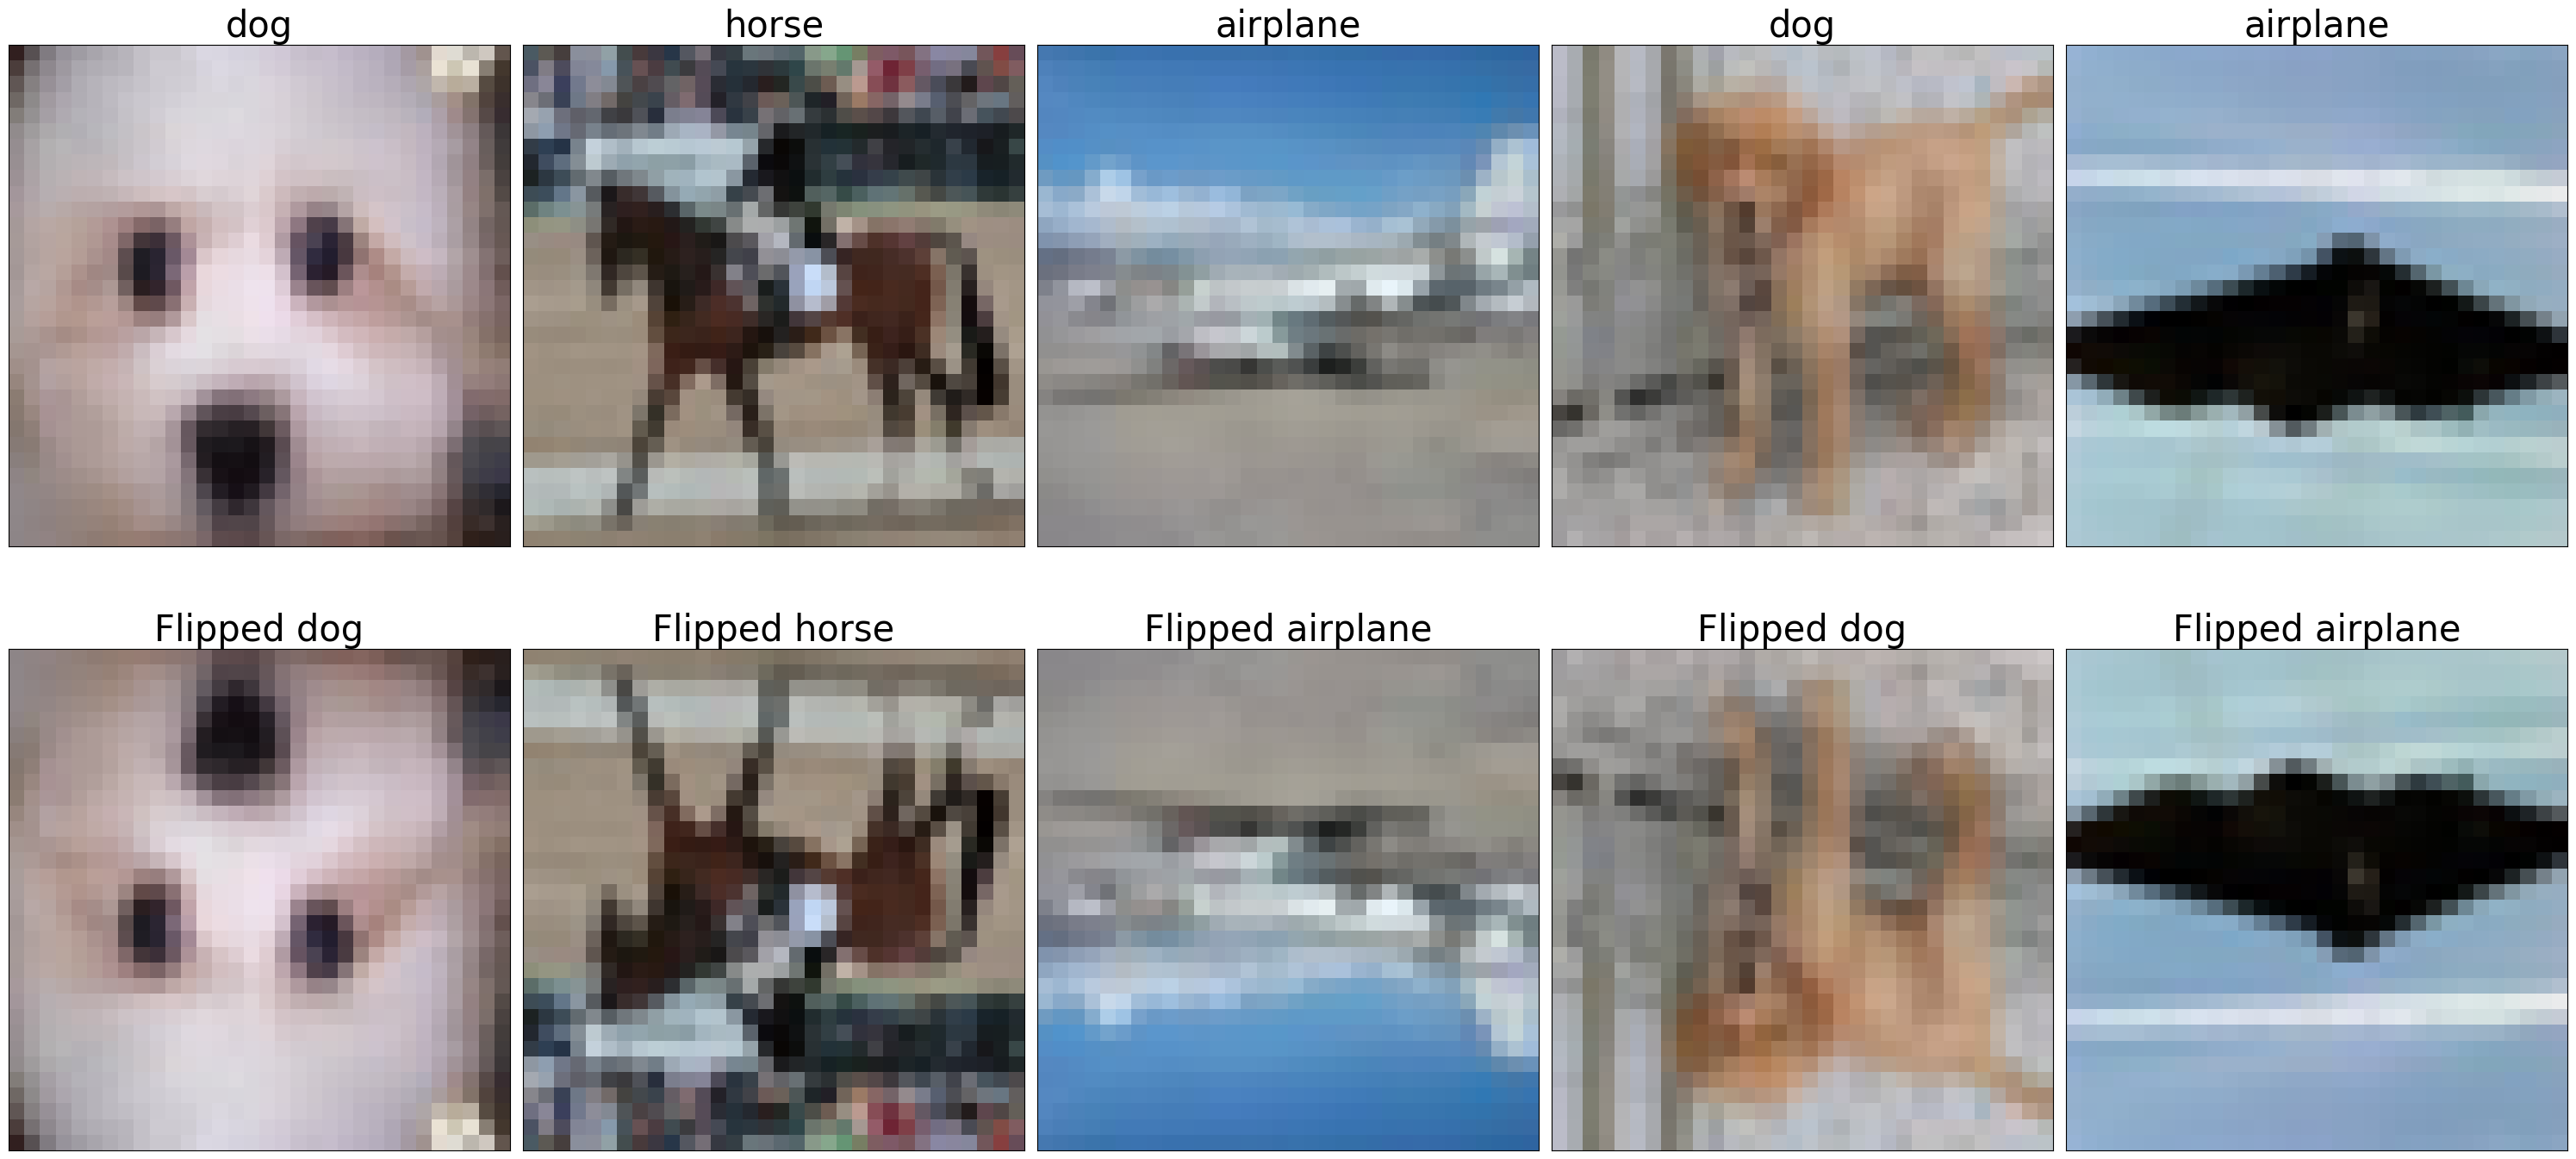

In [7]:
# load test set
dataset = CIFAR10(root=".", train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1)

# load some data
for x, y in loader:
    break


# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])

for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={"size": 30})
    ax.set_xticks([])
    ax.set_yticks([])


fig.tight_layout()

### Zadanie 2. Augmentacja danych (1 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/vision/stable/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twojego modelu z poprzedniego zadania. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

In [8]:
# tutaj dodaj wybrane augumentcje danych treningowych i załaduj testowe

transform_train = transforms.Compose([
    RandomHorizontalFlip(),
    RandomRotation(20),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = CIFAR10(root='.',
                        train=True,
                        download=True,
                        transform=transform_train)

test_dataset = CIFAR10(root='.',
                       train=False,
                       download=True,
                       transform=transform_test)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
learning_rate = 0.001
epochs = 20

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')

#Final evaluation on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Final Test Accuracy: {accuracy:.4f}')

Epoch 1/20, Loss: 1.5609, Accuracy: 0.5726
Epoch 2/20, Loss: 1.2907, Accuracy: 0.6634
Epoch 3/20, Loss: 0.6195, Accuracy: 0.7095
Epoch 4/20, Loss: 0.7188, Accuracy: 0.7499
Epoch 5/20, Loss: 1.0252, Accuracy: 0.7506
Epoch 6/20, Loss: 0.8978, Accuracy: 0.7696
Epoch 7/20, Loss: 0.2658, Accuracy: 0.7648
Epoch 8/20, Loss: 0.5631, Accuracy: 0.7845
Epoch 9/20, Loss: 0.4007, Accuracy: 0.7912
Epoch 10/20, Loss: 0.4030, Accuracy: 0.7920
Epoch 11/20, Loss: 0.6831, Accuracy: 0.7906
Epoch 12/20, Loss: 0.4268, Accuracy: 0.8010
Epoch 13/20, Loss: 0.7412, Accuracy: 0.7993
Epoch 14/20, Loss: 0.4867, Accuracy: 0.8112
Epoch 15/20, Loss: 0.0693, Accuracy: 0.8068
Epoch 16/20, Loss: 0.2903, Accuracy: 0.8024
Epoch 17/20, Loss: 0.8067, Accuracy: 0.8055
Epoch 18/20, Loss: 0.1483, Accuracy: 0.8161
Epoch 19/20, Loss: 1.1908, Accuracy: 0.8148
Epoch 20/20, Loss: 0.4697, Accuracy: 0.8094
Final Test Accuracy: 0.8094
